In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/content/creditcard.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

fraud_df = pd.read_csv('/content/creditcard.csv')
print(fraud_df.shape)
print(fraud_df.head())
missing_values = fraud_df.isnull().sum()
print(missing_values)



(17918, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V2

In [ ]:

fraud_df=fraud_df.dropna()
df = fraud_df.copy()
print(fraud_df.shape)

(93180, 31)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 74374, number of negative: 74374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 148748, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                     accuracy  f1_score    recall precision
SVM                  0.971507  0.130933  0.930233  0.070423
Logistic Regression  0.978161  0.164271  0.930233   0.09009
KNN                  0.997693  0.644628  0.906977       0.5
XGBoost              0.999624   0.91954  0.930233  0.909091
Random Forest        0.999571  0.904762  0.883721  0.926829
LightGBM              0.99941  0.879121  0.930233  0.833333


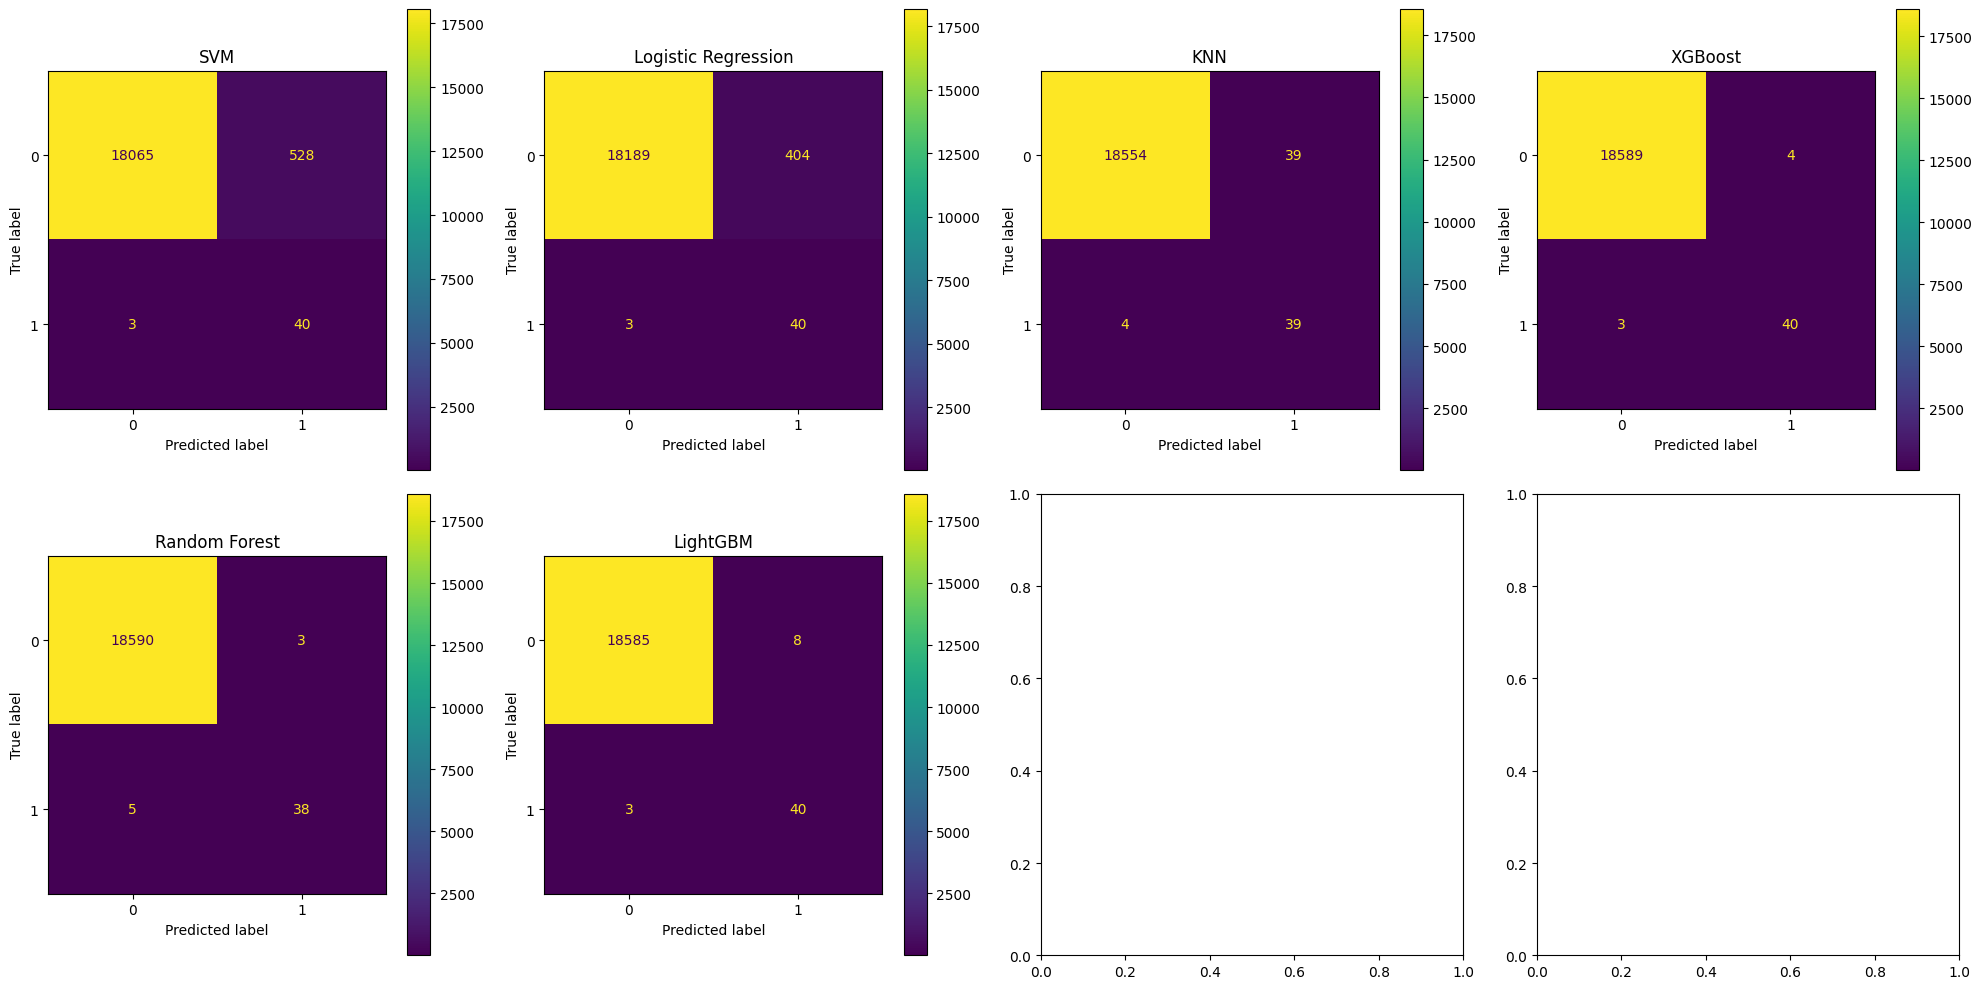

In [ ]:



from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier


X = df.drop('Class', axis=1)
y = df['Class']


X.fillna(X.mean(), inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


models = {
    "SVM": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    #"CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}


results = {}
for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    results[model_name] = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "f1_score": f1,
        "recall": recall,
        "precision": precision
    }


metrics_df = pd.DataFrame(results).T[['accuracy', 'f1_score', 'recall', 'precision']]
print(metrics_df)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()

for ax, (model_name, metrics) in zip(axes, results.items()):
    cm = metrics["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, values_format='d')
    ax.set_title(model_name)

plt.tight_layout()
plt.show()


In [ ]:
# prompt: give output of class columns with value counts for fraudulent and non fraudulent transactions

fraud_class_counts = fraud_df['Class'].value_counts()
print(fraud_class_counts)


Class
0.0    17836
1.0       81
Name: count, dtype: int64
